Đang tải mô hình từ checkpoint: swin_unet_best_pytorch.pth


C:\Users\Admin\AppData\Local\Temp\ipykernel_29152\3683392357.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVI

Đã tải mô hình thành công.

Đang xử lý ảnh: C:\Users\Admin\Documents\Python Project\DPL Crack detection\archive (2)\UDTIRI-Crack\UDTIRI-Crack Generalization2\image\019.png


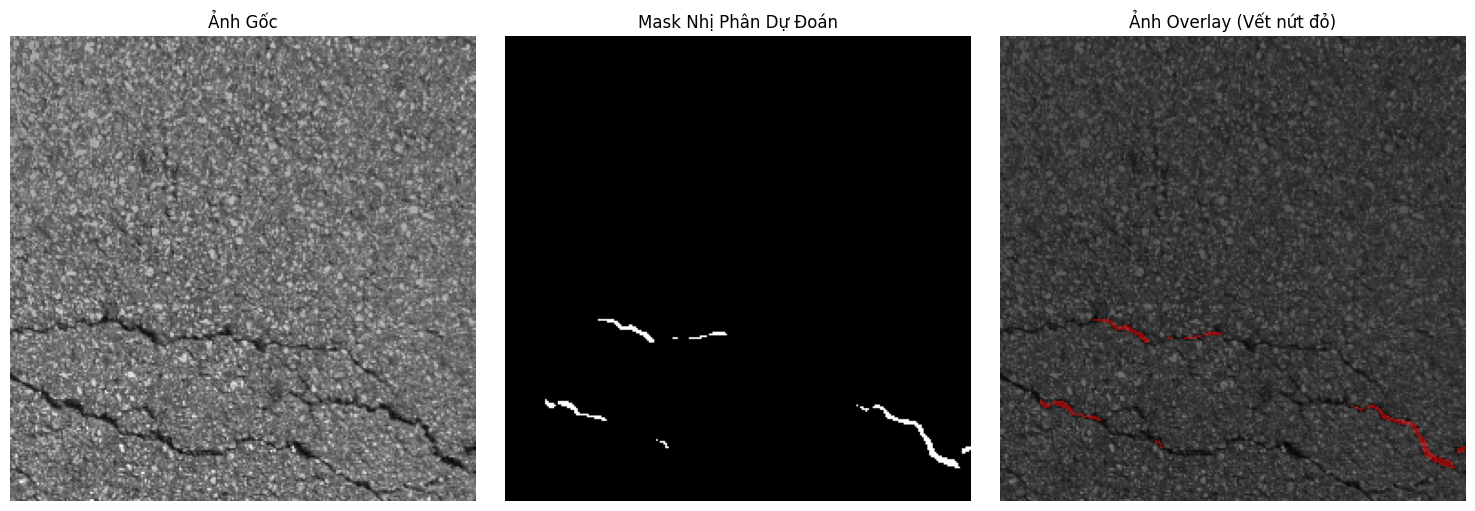


Quá trình dự đoán và hiển thị hoàn tất.


In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from transformers import SwinConfig, SwinModel
import matplotlib.pyplot as plt # Import thư viện Matplotlib

# --- Cấu hình và Định nghĩa Mô hình (Giống như trong file huấn luyện của bạn) ---
IMG_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa lại các lớp ConvBlock, DecoderBlock, SwinUNet
# (Nếu bạn đang chạy file này riêng biệt, hãy đảm bảo bạn có các định nghĩa này ở đây)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        if skip_channels > 0:
            self.conv_block = ConvBlock(out_channels + skip_channels, out_channels)
        else:
            self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip_features=None):
        x = self.upsample(x)
        
        if skip_features is not None and skip_features.size(1) > 0:
            if x.shape[2:] != skip_features.shape[2:]:
                diffY = skip_features.size()[2] - x.size()[2]
                diffX = skip_features.size()[3] - x.size()[3]
                x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])
            x = torch.cat([x, skip_features], dim=1)
        
        x = self.conv_block(x)
        return x

class SwinUNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1):
        super().__init__()
        self.IMG_SIZE = IMG_SIZE

        config = SwinConfig(image_size=self.IMG_SIZE, num_channels=input_channels, 
                            patch_size=4, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                            window_size=7, mlp_ratio=4., qkv_bias=True, hidden_dropout_prob=0.0, 
                            attention_probs_dropout_prob=0.0, drop_path_rate=0.1, 
                            hidden_act="gelu", use_absolute_embeddings=False, 
                            patch_norm=True, initializer_range=0.02, layer_norm_eps=1e-05,
                            out_features=["stage1", "stage2", "stage3", "stage4"])
        self.swin = SwinModel(config)

        self.bottleneck = ConvBlock(config.embed_dim * 8, config.embed_dim * 8)

        self.decoder4 = DecoderBlock(in_channels=config.embed_dim * 8, skip_channels=config.embed_dim * 4, out_channels=config.embed_dim * 4)
        self.decoder3 = DecoderBlock(in_channels=config.embed_dim * 4, skip_channels=config.embed_dim * 2, out_channels=config.embed_dim * 2)
        self.decoder2 = DecoderBlock(in_channels=config.embed_dim * 2, skip_channels=config.embed_dim * 1, out_channels=config.embed_dim * 1)
        
        self.decoder1 = DecoderBlock(in_channels=config.embed_dim * 1, skip_channels=0, out_channels=config.embed_dim // 2)

        self.final_upsample = DecoderBlock(in_channels=config.embed_dim // 2, skip_channels=0, out_channels=config.embed_dim // 4)

        self.final_conv = nn.Conv2d(config.embed_dim // 4, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        outputs = self.swin(pixel_values=x, output_hidden_states=True)
        encoder_features = []

        hs0 = outputs.hidden_states[0]
        batch_size, num_patches, embed_dim = hs0.shape
        side = int(np.sqrt(num_patches))
        encoder_features.append(hs0.permute(0, 2, 1).reshape(batch_size, embed_dim, side, side))

        hs1 = outputs.hidden_states[1]
        batch_size, num_patches, embed_dim = hs1.shape
        side = int(np.sqrt(num_patches))
        encoder_features.append(hs1.permute(0, 2, 1).reshape(batch_size, embed_dim, side, side))

        hs2 = outputs.hidden_states[2]
        batch_size, num_patches, embed_dim = hs2.shape
        side = int(np.sqrt(num_patches))
        encoder_features.append(hs2.permute(0, 2, 1).reshape(batch_size, embed_dim, side, side))

        x_bottleneck = outputs.hidden_states[4]
        batch_size, num_patches, embed_dim = x_bottleneck.shape
        side = int(np.sqrt(num_patches))
        x_bottleneck = x_bottleneck.permute(0, 2, 1).reshape(batch_size, embed_dim, side, side)
        
        x = self.bottleneck(x_bottleneck)

        x = self.decoder4(x, encoder_features[2])
        x = self.decoder3(x, encoder_features[1])
        x = self.decoder2(x, encoder_features[0])
        x = self.decoder1(x)
        x = self.final_upsample(x)

        outputs = self.final_conv(x)
        outputs = self.sigmoid(outputs)

        return outputs

# --- Đường dẫn đến ảnh và checkpoint ---
image_path = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\archive (2)\UDTIRI-Crack\UDTIRI-Crack Generalization2\image\019.png'
checkpoint_path = 'swin_unet_best_pytorch.pth' # Tên file checkpoint của bạn

# --- Tải và chuẩn bị mô hình ---
model = SwinUNet(input_channels=3, num_classes=1).to(DEVICE)

if os.path.exists(checkpoint_path):
    print(f"Đang tải mô hình từ checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    print("Đã tải mô hình thành công.")
else:
    print(f"Lỗi: Không tìm thấy file checkpoint tại {checkpoint_path}. Vui lòng kiểm tra lại đường dẫn.")
    exit()

model.eval() # Đặt mô hình ở chế độ đánh giá

# --- Hàm tiền xử lý ảnh (giống như trong Dataset) ---
def preprocess_image(image_path, target_size=IMG_SIZE, window_size=4):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc tệp ảnh: {image_path}")
    
    h, w = img.shape[:2]
    new_h = max(target_size, ((h + window_size - 1) // window_size) * window_size)
    new_w = max(target_size, ((w + window_size - 1) // window_size) * window_size)

    padded_img = np.zeros((new_h, new_w, 3), dtype=img.dtype)
    padded_img[:h, :w, :] = img

    cropped_img = padded_img[:target_size, :target_size, :]

    img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB) # Chuyển BGR sang RGB để hiển thị gốc
    img_processed = img_rgb.astype(np.float32) / 255.0 # Chuẩn hóa cho mô hình
    img_tensor = torch.from_numpy(img_processed).permute(2, 0, 1).unsqueeze(0)
    return img_tensor, img_rgb # Trả về tensor để dự đoán và ảnh gốc RGB để hiển thị

# --- Hàm hậu xử lý và hiển thị mask bằng Matplotlib ---
def postprocess_and_display_matplotlib(original_img_rgb, predicted_mask, threshold=0.5):
    predicted_mask_np = predicted_mask.squeeze().cpu().numpy()

    # Áp dụng ngưỡng để tạo mask nhị phân (0 hoặc 1)
    binary_mask = (predicted_mask_np > threshold).astype(np.uint8) 

    # Tạo ảnh overlay để dễ nhìn vết nứt trên ảnh gốc
    # Đảm bảo original_img_rgb là float cho phép tính blend, sau đó chuyển về uint8
    original_img_float = original_img_rgb.astype(np.float32) / 255.0 # Chuẩn hóa lại về 0-1 cho blending

    colored_mask = np.zeros_like(original_img_float)
    colored_mask[binary_mask == 1] = [1.0, 0.0, 0.0] # Màu đỏ cho vết nứt (giá trị 0-1)

    alpha = 0.5 # Độ trong suốt của mask
    overlay_img = (original_img_float * (1 - alpha) + colored_mask * alpha) * 255
    overlay_img = overlay_img.astype(np.uint8) # Chuyển về 0-255 uint8 để hiển thị

    # Tạo figure và subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 hàng, 3 cột
    
    # Ảnh gốc
    axes[0].imshow(original_img_rgb)
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    # Mask nhị phân
    axes[1].imshow(binary_mask, cmap='gray') # 'gray' colormap cho ảnh nhị phân
    axes[1].set_title("Mask Nhị Phân Dự Đoán")
    axes[1].axis('off')

    # Ảnh Overlay
    axes[2].imshow(overlay_img)
    axes[2].set_title("Ảnh Overlay (Vết nứt đỏ)")
    axes[2].axis('off')

    plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các subplot
    plt.show() # Hiển thị hình

# --- Thực hiện dự đoán ---
print(f"\nĐang xử lý ảnh: {image_path}")
input_tensor, original_img_rgb = preprocess_image(image_path)
input_tensor = input_tensor.to(DEVICE)

with torch.no_grad():
    prediction = model(input_tensor)

# --- Hậu xử lý và hiển thị kết quả ---
postprocess_and_display_matplotlib(original_img_rgb, prediction, threshold=0.5)

print("\nQuá trình dự đoán và hiển thị hoàn tất.")